In [1]:
!pip install pennylane
!pip install pennylane-qiskit
!pip install qiskit
!pip install qml
#!pip install tensorflow-macos

  Using cached qml-0.4.0.27.tar.gz (41 kB)
  Running setup.py clean for qml
Failed to build qml
    Running setup.py install for qml: started
    Running setup.py install for qml: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\gueha\anaconda3\envs\quantum\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\gueha\\AppData\\Local\\Temp\\pip-install-9xbrlw16\\qml_fa54ab6975f74b22ac20f3b75ebcf7b9\\setup.py'"'"'; __file__='"'"'C:\\Users\\gueha\\AppData\\Local\\Temp\\pip-install-9xbrlw16\\qml_fa54ab6975f74b22ac20f3b75ebcf7b9\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\gueha\AppData\Local\Temp\pip-wheel-on422oov'
       cwd: C:\Users\gueha\AppData\Local\Temp\pip-install-9xbrlw16\qml_fa54ab6975f74b22ac20f3b75ebcf7b9\
  Complete output (69 lines):
  MKL-discover: MKLROOT was not set
  running bdist_wheel
  running build
  running config_cc
  INFO: unifing con

In [2]:
import warnings

#import pickle
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import scipy
from scipy.io import wavfile

import librosa
import librosa.display

import time as ti

import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers  import Conv2D, MaxPooling2D, Dense,Flatten, GRU, BatchNormalization, Conv1D, Dropout, Bidirectional,MaxPooling1D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, BatchNormalization, Conv1D, GRU, TimeDistributed, Activation, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import categorical_crossentropy

import qiskit
import qiskit.providers.aer.noise as noise
from qiskit import IBMQ

## Local Definition 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
noise_mode = True # for running at QPU

# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

n_w = 4 # numbers of wires def 2


if  noise_mode == True:
    #dev = qml.device('qiskit.aer', wires= n_w, noise_model=noise_model)
    #dev = qml.device('qiskit.ibmq', wires=n_w, backend='ibmq_qasm_simulator', provider=provider)
    dev = qml.device("default.mixed", wires= n_w)
else:
    #local quantum simulator
    dev = qml.device("default.qubit", wires= n_w)
    

In [4]:
n_layers = 1

# Random circuit parameters
rand_params1 = np.random.uniform(high= 2 * np.pi, size=(n_layers, n_w)) # def 2, n_w = 4

n_layers = 2

# Random circuit parameters
rand_params2 = np.random.uniform(high= 2 * np.pi, size=(n_layers, n_w)) # def 2, n_w = 4

n_layers = 3

# Random circuit parameters
rand_params3 = np.random.uniform(high= 2 * np.pi, size=(n_layers, n_w)) # def 2, n_w = 4

n_layers = 4

# Random circuit parameters
rand_params4 = np.random.uniform(high= 2 * np.pi, size=(n_layers, n_w)) # def 2, n_w = 4

In [5]:
@qml.qnode(dev)
def circuit(layer=1,phi=None):
    # Encoding of 4 classical input values
    for j in range(n_w):
        qml.RY(np.pi * phi[j], wires=j)
        qml.DepolarizingChannel(0.1, wires=j)

    # Random quantum circuit
    if(layer==1):
      RandomLayers(rand_params1, wires=list(range(n_w)))
    elif (layer==2):
      RandomLayers(rand_params2, wires=list(range(n_w)))
    elif (layer==3):
      RandomLayers(rand_params3, wires=list(range(n_w)))
    else:
      RandomLayers(rand_params4, wires=list(range(n_w)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_w)]

In [6]:
def quanv(image, kr=2, layer=1):
    h_feat, w_feat, ch_n = image.shape
    """Convolves the input speech with many applications of the same quantum circuit."""
    out = np.zeros((h_feat//kr, w_feat//kr, n_w))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, h_feat-1, kr):
        for k in range(0, w_feat-1, kr):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                layer,
                # kernal 3 ## phi=[image[j, k, 0], image[j, k + 1, 0], image[j, k + 2, 0], image[j + 1, k, 0], 
                # image[j + 1, k + 1, 0], image[j + 1, k +2 , 0],image[j+2, k, 0], image[j+2, k+1, 0], image[j+2, k+2, 0]]
                phi=[image[j, k, 0], image[j, k + 1, 0], image[j + 1, k, 0], image[j + 1, k + 1, 0]]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(n_w):
                out[j // kr, k // kr, c] = q_results[c]
    return out

In [7]:
def gen_qspeech(x_train, x_valid, kr, layer=1): # kernal size = 2x2 or 3x3
    q_train = []
    print("Quantum pre-processing of train Speech:")
    for idx, img in enumerate(x_train):
        print("{}/{}        ".format(idx + 1, len(x_train)), end="\r")
        q_train.append(quanv(img, kr, layer))
    q_train = np.asarray(q_train)

    q_valid = []
    print("\nQuantum pre-processing of test Speech:")
    for idx, img in enumerate(x_valid):
        print("{}/{}        ".format(idx + 1, len(x_valid)), end="\r")
        q_valid.append(quanv(img, kr))
    q_valid = np.asarray(q_valid)
    
    return q_train, q_valid

In [8]:
def plot_acc_loss(q_history, x_history, v_history, data_ix):

    plt.figure()
    plt.style.use("seaborn")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

    ax1.plot(v_history.history["val_accuracy"], "-ok", label="Baseline Attn-BiLSTM")
    ax1.plot(q_history.history["val_accuracy"], "-ob", label="With Quanv Layer")
    ax1.plot(x_history.history["val_accuracy"], "-og", label="With Conv Layer")
    ax1.set_ylabel("Accuracy")
    ax1.set_ylim([0, 1])
    ax1.set_xlabel("Epoch")
    ax1.legend()

    ax2.plot(v_history.history["val_loss"], "-ok", label="Baseline Attn-BiLSTM")
    ax2.plot(q_history.history["val_loss"], "-ob", label="With Quanv Layer")
    ax2.plot(x_history.history["val_loss"], "-og", label="With Conv Layer")
    ax2.set_ylabel("Loss")
    #ax2.set_ylim(top=5.5)
    ax2.set_xlabel("Epoch")
    ax2.legend()
    plt.tight_layout()
    plt.savefig("images/"+ data_ix +"_conv_speech_loss.png")

In [9]:
def show_speech(x_train, q_train, use_ch, idx, tmp = "tmp"):
    plt.figure()
    plt.subplot(5, 1, 1)
    if use_ch != True:
        librosa.display.specshow(librosa.power_to_db(x_train[idx,:,:,0], ref=np.max))
    else:
        librosa.display.specshow(librosa.power_to_db(x_train[idx,:,:], ref=np.max))
    plt.title('Input Speech: ' + tmp)

    for i in range(4):
        plt.subplot(5, 1, i+2)
        librosa.display.specshow(librosa.power_to_db(q_train[idx,:,:,i], ref=np.max))
        plt.title('Channel '+str(i+1)+': Quantum Compressed Speech')


    plt.tight_layout()
    plt.savefig("images/speech_encoder_" + tmp + ".png")

In [10]:
def show_stft_speech(x_train, q_train, use_ch, idx, tmp = "tmp"):
    plt.figure()
    plt.subplot(5, 1, 1)
    if use_ch != True:
        librosa.display.specshow(librosa.amplitude_to_db(x_train[idx,:,:,0], ref=np.max))
    else:
        librosa.display.specshow(librosa.amplitude_to_db(x_train[idx,:,:,0], ref=np.max))
    plt.title('Input Speech: ' + tmp)
    
    for i in range(4):
        plt.subplot(5, 1, i+2)
        librosa.display.specshow(librosa.amplitude_to_db(q_train[idx,:,:,1], ref=np.max))
        plt.title('Channel '+str(i+1)+': Quantum Compressed Speech')


In [11]:
def dense_Model(x, labels):
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    if len(x.shape) >= 3:
        h_feat,w_feat,ch_size = x.shape
        input_layer = keras.layers.Input(shape=(h_feat,w_feat,ch_size))
    else:
        h_feat,w_feat = x.shape
        input_layer = keras.layers.Input(shape=(h_feat,w_feat))
    model = keras.models.Sequential([
        input_layer,
        keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True),
        keras.layers.Flatten(),
        keras.layers.Dense(64),
        keras.layers.Dense(64),
        keras.layers.Dense(32),
        keras.layers.Dense(len(labels), activation="softmax")
    ])

    model.compile(
        optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [12]:
# define cnn model
def cnn_Model(h_feat, w_feat, labels):       
	model = Sequential()
	model.add(Conv2D(6, (2, 2), padding='valid', activation='relu', input_shape=(h_feat, w_feat, 1)))
	#model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(len(labels), activation='softmax'))
	# compile model
	opt = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [13]:
def attrnn_Model(x_in, labels, use_cnn=False, ablation = False):
    # simple LSTM
    rnn_func = L.LSTM
    use_Unet = True

    if len(x_in.shape) >= 3:
        h_feat,w_feat,ch_size = x_in.shape
        inputs = keras.layers.Input(shape=(h_feat, w_feat, ch_size))
    else:
        h_feat, w_feat = x_in.shape
        inputs = keras.layers.Input(shape=(h_feat, w_feat))

    inputs = L.Input(shape=(h_feat, w_feat, ch_size))

    if use_cnn == True:
        #x = L.Permute((2, 1, 3))(inputs)
        # First conv block
        x = L.Conv2D(
            32,
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
            name="Conv1",
        )(inputs)
        x = L.MaxPooling2D((2, 2), name="pool1")(x)

        # Second conv block
        x = L.Conv2D(
            64,
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
            name="Conv2",
        )(x)
        x = L.MaxPooling2D((2, 2), name="pool2")(x)
    else:
        x=inputs
        
    if ablation == True:
        x = L.Conv2D(4, (1, 1), strides=(2, 2), activation='relu', padding='same', name='abla_conv')(x)
        x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)
    else:
        x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

    # note that Melspectrogram puts the sequence in shape (batch_size, melDim, timeSteps, 1)
    # we would rather have it the other way around for LSTMs

    x = L.Permute((2, 1, 3))(x)

    if use_Unet == True:
        x = L.Conv2D(16, (5, 1), activation='relu', padding='same', name='ConvUp')(x)
        up = L.BatchNormalization()(x)
        x = L.Conv2D(32, (5, 1), activation='relu', padding='same', name='ConvDown1')(up)
        x = L.BatchNormalization()(x)
        x = L.Conv2D(16, (5, 1), activation='relu', padding='same', name='ConvDown2')(x)
        down = L.BatchNormalization()(x)
        merge = L.Concatenate(axis=3)([up,down])
        x = L.Conv2D(1, (5, 1), activation='relu', padding='same', name='ConvMerge')(merge)
        x = L.BatchNormalization()(x)
    else:
        x = L.Conv2D(10, (5, 1), activation='relu', padding='same')(x)
        x = L.BatchNormalization()(x)
        x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
        x = L.BatchNormalization()(x)

    x = L.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim')(x)


    x = L.Bidirectional(rnn_func(64, return_sequences=True)
                        )(x)  # [b_s, seq_len, vec_dim]
    x = L.Bidirectional(rnn_func(64, return_sequences=True)
                        )(x)  # [b_s, seq_len, vec_dim]

    xFirst = L.Lambda(lambda q: q[:, -1])(x)  # [b_s, vec_dim]
    query = L.Dense(128)(xFirst)

    # dot product attention
    attScores = L.Dot(axes=[1, 2])([query, x])
    attScores = L.Softmax(name='attSoftmax')(attScores)  # [b_s, seq_len]

    # rescale sequence
    attVector = L.Dot(axes=[1, 1])([attScores, x])  # [b_s, vec_dim]

    x = L.Dense(64, activation='relu')(attVector)
    x = L.Dense(32)(x)

    output = L.Dense(len(labels), activation='softmax', name='output')(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(
        optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [14]:
#%cd speech_quantum_dl
#from google.colab import drive

#drive.mount('/content/drive/', force_remount=True)
#%cd '/content/drive/My Drive/QuantumTeams/Pennylane Speech/'
#from google.colab import drive
#drive.mount("/content/drive", force_remount=True)
#!cd /content/drive/My\ Drive/Michael\ COVID\ audio\ data


In [15]:
data_ix = ti.strftime("%m%d_%H%M")
SAVE_PATH = "data_quantum/" # Data saving folder
#train_audio_path = '/content/drive/My Drive/QuantumTeams/Pennylane Speech'
train_audio_path = './'

In [86]:
def gen_mel(labels, train_audio_path, sr, port):
    all_wave = []
    all_label = []
    maxL=0
    minL=358321
    for label in tqdm(labels):
        waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
        for num, wav in enumerate(waves, 0):
            #print(wav)
            y, _ = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = sr)
            print(y.shape)
            if len(y)>maxL:
                maxL =len(y)
            if len(y)<minL:
                minL =len(y)
            if num % port ==0:   # take 1/port samples
                if(len(y)>= 96000) :
                    mel_feat = librosa.feature.melspectrogram(y=y[0:96000], sr=sr, n_fft=1024, hop_length=128, center=True, power=1.0, n_mels=60, fmin=40.0, fmax=sr/2) #y[0:sr]
                    all_wave.append(np.expand_dims(mel_feat, axis=2))
                    all_label.append(label)
    print(maxL)
    print(minL)
    return all_wave, all_label

In [17]:
def gen_stft(labels, train_audio_path, sr, port):
    all_wave = []
    all_label = []
    windowLength = 1024
    window = scipy.signal.hamming(windowLength, sym=False)
    overlap      = round(0.25 * windowLength) # overlap of 75%
    for label in tqdm(labels):
        waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
        for num, wav in enumerate(waves, 0):
            y, _ = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = sr)
            if num % port ==0:   # take 1/port samples
                if(len(y)== sr) :
                    stft_feat = librosa.stft(y, n_fft=windowLength, win_length=windowLength, hop_length=128,
                            window=window, center=True)
                    all_wave.append(np.expand_dims(stft_feat, axis=2))
                    all_label.append(label)
    
    return all_wave, all_label

In [18]:
#want to change eps, bsize, sr to optimize
eps = 100
bsize = 16
sr = 48000
net = 1
mel = 1
quanv_mode = 1
# Quantum Layers
ql1 = 1
ql2 = 0
ql3 = 0
ql4 = 0
port = 1
labels = [
    'control','dysarthric'
]

In [19]:
def gen_train(labels, train_audio_path, sr, port):
    all_wave, all_label = gen_mel(labels, train_audio_path, sr, port)
    #all_wave, all_label = gen_stft(labels, train_audio_path, sr, port)

    label_enconder = LabelEncoder()
    y = label_enconder.fit_transform(all_label)
    classes = list(label_enconder.classes_)
    y = keras.utils.to_categorical(y, num_classes=len(labels))

    from sklearn.model_selection import train_test_split
    x_train, x_valid, y_train, y_valid = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)
    h_feat, w_feat, _ = x_train[0].shape
    np.save(SAVE_PATH + "41n_x_train_speechd.npy", x_train)
    np.save(SAVE_PATH + "41n_x_test_speechd.npy", x_valid)
    np.save(SAVE_PATH + "41n_y_train_speechd.npy", y_train)
    np.save(SAVE_PATH + "41n_y_test_speechd.npy", y_valid)
    print("===== Shape", h_feat, w_feat)

    return x_train, x_valid, y_train, y_valid

In [20]:
def gen_quanv(x_train, x_valid, kr, layer):
    print("Kernal = ", kr)
    q_train, q_valid = gen_qspeech(x_train, x_valid, kr, layer)

    np.save(SAVE_PATH + "4"+str(layer) + "n_q_train_speechd.npy", q_train)
    np.save(SAVE_PATH + "4"+str(layer) + "n_q_test_speechd.npy", q_valid)

    return q_train, q_valid

In [87]:
if mel == 1:
    x_train, x_valid, y_train, y_valid = gen_train(labels, train_audio_path, sr, port) 
else:
    x_train = np.load(SAVE_PATH + "41n_x_train_speechd.npy")
    x_valid = np.load(SAVE_PATH + "41n_x_test_speechd.npy")
    y_train = np.load(SAVE_PATH + "41n_y_train_speechd.npy")
    y_valid = np.load(SAVE_PATH + "41n_y_test_speechd.npy")

  0%|          | 0/2 [00:00<?, ?it/s]

(106779,)
(106779,)
(106779,)
(106779,)
(106779,)
(106779,)
(106779,)
(102147,)
(102147,)
(102147,)
(102147,)
(102147,)
(102147,)
(102147,)
(95112,)
(95112,)
(95112,)
(95112,)
(95112,)
(95112,)
(95112,)
(108705,)
(108705,)
(108705,)
(108705,)
(108705,)
(108705,)
(108705,)
(101967,)
(101967,)
(101967,)
(101967,)
(101967,)
(101967,)
(101967,)
(96777,)
(96777,)
(96777,)
(96777,)
(96777,)
(96777,)
(96777,)
(103047,)
(103047,)
(103047,)
(103047,)
(103047,)
(103047,)
(103047,)
(94329,)
(94329,)
(94329,)
(94329,)
(94329,)
(94329,)
(94329,)
(97881,)
(97881,)
(97881,)
(97881,)
(97881,)
(97881,)
(97881,)
(92484,)
(92484,)
(92484,)
(92484,)
(92484,)
(92484,)
(92484,)
(112413,)
(112413,)
(112413,)
(112413,)
(112413,)
(112413,)
(112413,)
(85608,)
(85608,)
(85608,)
(85608,)
(85608,)
(85608,)
(85608,)
(72837,)
(72837,)
(72837,)
(72837,)
(72837,)
(72837,)


 50%|█████     | 1/2 [00:05<00:05,  5.71s/it]

(72837,)
(294789,)
(294789,)
(294789,)
(294789,)
(294789,)
(294789,)
(294789,)
(201075,)
(201075,)
(201075,)
(201075,)
(201075,)
(201075,)
(201075,)
(149607,)
(149607,)
(149607,)
(149607,)
(149607,)
(149607,)
(149607,)
(126465,)
(126465,)
(126465,)
(126465,)
(126465,)
(126465,)
(126465,)
(2304081,)
(2304081,)
(2304081,)
(2304081,)
(153207,)
(153207,)
(153207,)
(153207,)
(153207,)
(416226,)
(416226,)
(416226,)
(416226,)
(416226,)
(416226,)
(416226,)
(168531,)
(168531,)
(168531,)
(168531,)
(168531,)
(168531,)
(168531,)
(124494,)
(124494,)
(124494,)
(124494,)
(124494,)
(124494,)
(124494,)
(153672,)
(153672,)
(153672,)
(153672,)
(153672,)
(153672,)
(153672,)
(115047,)
(115047,)
(115047,)
(115047,)
(115047,)
(115047,)
(115047,)
(264285,)
(264285,)
(264285,)
(264285,)
(264285,)
(264285,)
(307995,)
(307995,)
(307995,)
(307995,)
(307995,)
(307995,)
(127206,)
(127206,)
(127206,)
(127206,)
(127206,)
(127206,)
(127206,)
(144372,)
(144372,)
(144372,)
(144372,)


100%|██████████| 2/2 [00:22<00:00, 11.42s/it]

(144372,)
(144372,)
2304081
72837
===== Shape 60 751


In [63]:
print("Xtrain len:", len(x_train))
print("XValid len:", len(x_valid))

zero_val = 0
one_val = 0
for i in y_valid:
    # get(key, default) falls back to default if key is not present
    if i[1] == 1:
        one_val = one_val + 1
    else:
        zero_val = zero_val + 1

print("Valid count")
print("control:", one_val)
print("dysarthric:", zero_val)
print("Total:", one_val+zero_val)

zero_val = 0
one_val = 0
for i in y_train:
    # get(key, default) falls back to default if key is not present
    if i[1] == 1:
        one_val = one_val + 1
    else:
        zero_val = zero_val + 1

print("Train count")
print("control:", one_val)
print("dysarthric:", zero_val)
print("Total:", one_val+zero_val)

Xtrain len: 122
XValid len: 31
Valid count
control: 20
dysarthric: 11
Total: 31
Train count
control: 77
dysarthric: 45
Total: 122


([], [])

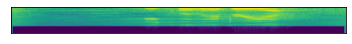

In [64]:
plt.figure()
plt.imshow(librosa.power_to_db(x_train[1,:,:,0], ref=np.max))
plt.xticks([])
plt.yticks([])

In [65]:
if quanv_mode == 1:
    if ql1 == 1:
        q_train1, q_valid1 = gen_quanv(x_train, x_valid, 2,1) 
    if ql2 == 1:
        q_train2, q_valid2 = gen_quanv(x_train, x_valid, 2,2)
    if ql3 == 1:
        q_train3, q_valid3 = gen_quanv(x_train, x_valid, 2,3) 
    if ql4 == 1:
        q_train4, q_valid4 = gen_quanv(x_train, x_valid, 2,4) 
else:
    if ql1 == 1:
        q_train1 = np.load(SAVE_PATH + "40n_q_train_speechd.npy")
        q_valid1 = np.load(SAVE_PATH + "40n_q_test_speechd.npy")
    if ql2 == 1:
        q_train2 = np.load(SAVE_PATH + "42n_q_train_speechd.npy")
        q_valid2 = np.load(SAVE_PATH + "42n_q_test_speechd.npy")
    if ql3 == 1:
        q_train3 = np.load(SAVE_PATH + "43n_q_train_speechd.npy")
        q_valid3 = np.load(SAVE_PATH + "43n_q_test_speechd.npy")
    if ql4 == 1:
        q_train4 = np.load(SAVE_PATH + "44n_q_train_speechd.npy")
        q_valid4 = np.load(SAVE_PATH + "44n_q_test_speechd.npy")


Kernal =  2
Quantum pre-processing of train Speech:
122/122        
Quantum pre-processing of test Speech:


In [66]:
def search(list, platform):
    for i in range(len(list)):
        if list[i] == platform:
            return True
    return False

In [67]:
def searchIndex(list, platform):
    for i in range(len(list)):
        if list[i] == platform:
            return i
    return -1

In [68]:
idx=[]
thislist = []
ii = 0
for jj in range(len(y_train)):
    label=labels[searchIndex(y_train[jj],1)]
    if search(thislist, label) == False:
        thislist.append(label)
        print(label)
        idx.append(jj)

control
dysarthric


In [69]:
librosa.amplitude_to_db(q_train1[2,:,:,1], ref=np.max)

array([[-8.32741428e-03, -1.22935547e-01, -4.26221574e-01, ...,
        -2.89202328e-01, -3.68151311e-01, -3.89872393e-01],
       [-4.77490162e-03, -1.54226076e-02, -3.93240182e-02, ...,
        -1.30179046e-02, -1.24207440e-02, -2.38430454e-02],
       [-4.35201843e-03, -3.16449404e-02, -5.16679531e-02, ...,
        -4.12731431e-03, -4.56042618e-03, -5.32609505e-03],
       ...,
       [-2.52426924e-09, -3.81438880e-10, -2.66453526e-15, ...,
        -2.66453526e-15, -6.62406312e-08, -2.92744744e-06],
       [-2.17246532e-09, -3.31235039e-10,  0.00000000e+00, ...,
        -4.44089210e-15, -5.67808698e-08, -2.52331346e-06],
       [-1.97670813e-09, -3.04776204e-10,  0.00000000e+00, ...,
        -5.32907052e-15, -5.10512885e-08, -2.28546282e-06]])

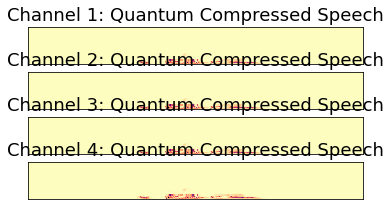

In [70]:
plt.figure()
for i in range(4):
    plt.subplot(5, 1, i+2)
    librosa.display.specshow(librosa.amplitude_to_db(q_train1[0,:,:,1], ref=np.max))
    plt.title('Channel '+str(i+1)+': Quantum Compressed Speech')

In [71]:
#S_db=librosa.amplitude_to_db(x_train[0,:,:,0],ref=np.max)
#plt.figure()
#librosa.display.specshow(S_db)
#plt.colorbar()

In [72]:
#for jj in range(len(idx)):
    #show_speech(x_train, q_train, False, idx[jj], tmp = labels[searchIndex(y_train[jj],1)])
    #show_stft_speech(x_train, q_train, False, idx[jj], tmp = labels[searchIndex(y_train[jj],1)])

In [73]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.rcParams.update({'font.size': 15})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.title(title)
    plt.show()
    #%%

In [74]:
import IPython.display as ipd
import scipy
window = scipy.signal.hamming(1024, sym=False)

rev3 = librosa.feature.inverse.mel_to_audio(x_train[0,:,:,0], sr=sr, n_fft=1024,
                                                    hop_length=128,
                                                    win_length=1024, window=window,
                                                    center=True, pad_mode='reflect', power=1.0, n_iter=32, length=None)

ipd.Audio(data=rev3, rate=sr) # load a local WAV file

In [75]:
!pip install keras

In [76]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
## For Quanv Exp.
early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                           verbose=1, patience=10, min_delta=0.0001)

checkpoint = ModelCheckpoint('checkpoints/best_base_demo4d.hdf5', monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')

if net == 0:
    modelx = dense_Model(x_train[0], labels)
elif net == 1:
    modelx = attrnn_Model(x_train[0], labels, ablation=True)

modelx.summary()

x_history = modelx.fit(
    x=x_train, 
    y=y_train,
    epochs=eps, 
    callbacks=[checkpoint], 
    batch_size=bsize, 
    validation_data=(x_valid,y_valid)
)


keras.models.save_model(modelx, 'checkpoints/'+ data_ix + '_base_model_demod4.hdf5') 
modelx.save('checkpoints/'+ data_ix + '_base_demo4d.hdf5')

print("=== Batch Size: ", bsize)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 60, 751, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 abla_conv (Conv2D)             (None, 30, 376, 4)   8           ['input_10[0][0]']               
                                                                                                  
 batch_normalization_20 (BatchN  (None, 30, 376, 4)  16          ['abla_conv[0][0]']              
 ormalization)                                                                                    
                                                                                            

C:\Users\gueha\anaconda3\envs\quantum\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


8/8 [==============================] - ETA: 0s - loss: 0.6385 - accuracy: 0.5984
Epoch 1: val_accuracy improved from -inf to 0.64516, saving model to checkpoints\best_base_demo4d.hdf5
8/8 [==============================] - 8s 489ms/step - loss: 0.6385 - accuracy: 0.5984 - val_loss: 0.6448 - val_accuracy: 0.6452
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.5301 - accuracy: 0.7377
Epoch 2: val_accuracy did not improve from 0.64516
8/8 [==============================] - 3s 353ms/step - loss: 0.5301 - accuracy: 0.7377 - val_loss: 0.8767 - val_accuracy: 0.6452
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.3339 - accuracy: 0.8770
Epoch 3: val_accuracy did not improve from 0.64516
8/8 [==============================] - 3s 359ms/step - loss: 0.3339 - accuracy: 0.8770 - val_loss: 1.6525 - val_accuracy: 0.6452
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.3759 - accuracy: 0.8197
Epoch 4: val_accuracy did not improve from 0.645

8/8 [==============================] - ETA: 0s - loss: 1.7637e-04 - accuracy: 1.0000
Epoch 29: val_accuracy did not improve from 0.87097
8/8 [==============================] - 3s 361ms/step - loss: 1.7637e-04 - accuracy: 1.0000 - val_loss: 0.9030 - val_accuracy: 0.8710
Epoch 30/100
8/8 [==============================] - ETA: 0s - loss: 1.6869e-04 - accuracy: 1.0000
Epoch 30: val_accuracy did not improve from 0.87097
8/8 [==============================] - 3s 351ms/step - loss: 1.6869e-04 - accuracy: 1.0000 - val_loss: 0.8583 - val_accuracy: 0.8710
Epoch 31/100
8/8 [==============================] - ETA: 0s - loss: 1.5021e-04 - accuracy: 1.0000
Epoch 31: val_accuracy did not improve from 0.87097
8/8 [==============================] - 3s 343ms/step - loss: 1.5021e-04 - accuracy: 1.0000 - val_loss: 0.8109 - val_accuracy: 0.8710
Epoch 32/100
8/8 [==============================] - ETA: 0s - loss: 1.5814e-04 - accuracy: 1.0000
Epoch 32: val_accuracy did not improve from 0.87097
8/8 [=========

Epoch 58/100
8/8 [==============================] - ETA: 0s - loss: 7.5008e-05 - accuracy: 1.0000
Epoch 58: val_accuracy did not improve from 0.90323
8/8 [==============================] - 3s 346ms/step - loss: 7.5008e-05 - accuracy: 1.0000 - val_loss: 0.5014 - val_accuracy: 0.9032
Epoch 59/100
8/8 [==============================] - ETA: 0s - loss: 6.9202e-05 - accuracy: 1.0000
Epoch 59: val_accuracy did not improve from 0.90323
8/8 [==============================] - 3s 341ms/step - loss: 6.9202e-05 - accuracy: 1.0000 - val_loss: 0.5023 - val_accuracy: 0.9032
Epoch 60/100
8/8 [==============================] - ETA: 0s - loss: 6.8628e-05 - accuracy: 1.0000
Epoch 60: val_accuracy did not improve from 0.90323
8/8 [==============================] - 3s 340ms/step - loss: 6.8628e-05 - accuracy: 1.0000 - val_loss: 0.4992 - val_accuracy: 0.9032
Epoch 61/100
8/8 [==============================] - ETA: 0s - loss: 8.2950e-05 - accuracy: 1.0000
Epoch 61: val_accuracy did not improve from 0.90323
8

8/8 [==============================] - 3s 361ms/step - loss: 4.4140e-05 - accuracy: 1.0000 - val_loss: 0.0152 - val_accuracy: 1.0000
Epoch 87/100
8/8 [==============================] - ETA: 0s - loss: 4.4213e-05 - accuracy: 1.0000
Epoch 87: val_accuracy did not improve from 1.00000
8/8 [==============================] - 3s 363ms/step - loss: 4.4213e-05 - accuracy: 1.0000 - val_loss: 0.0146 - val_accuracy: 1.0000
Epoch 88/100
8/8 [==============================] - ETA: 0s - loss: 4.2945e-05 - accuracy: 1.0000
Epoch 88: val_accuracy did not improve from 1.00000
8/8 [==============================] - 3s 358ms/step - loss: 4.2945e-05 - accuracy: 1.0000 - val_loss: 0.0139 - val_accuracy: 1.0000
Epoch 89/100
8/8 [==============================] - ETA: 0s - loss: 4.4711e-05 - accuracy: 1.0000
Epoch 89: val_accuracy did not improve from 1.00000
8/8 [==============================] - 3s 356ms/step - loss: 4.4711e-05 - accuracy: 1.0000 - val_loss: 0.0134 - val_accuracy: 1.0000
Epoch 90/100
8/8 [

In [77]:
y_test=np.argmax(y_valid, axis=1)

1/1 [==============================] - 1s 1s/step

Conv Accuracy: 1.00



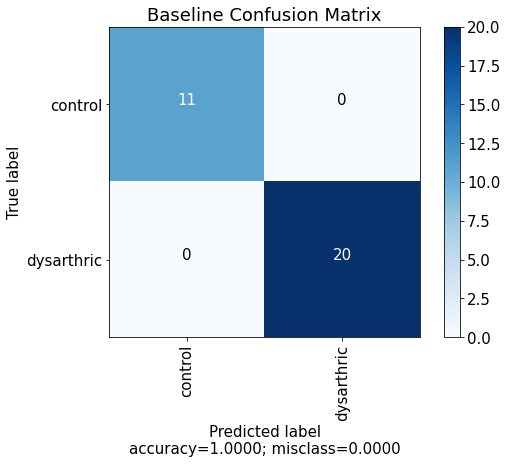

In [78]:
y_pred=modelx.predict(x_valid)
y_pred1 = (y_pred > 0.5) 

y_pred=np.argmax(y_pred, axis=1)
print('\nConv Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
cm = metrics.confusion_matrix(y_test, y_pred)


plot_confusion_matrix(cm , 
                      normalize    = False,
                      target_names = labels,
                      title        = "Baseline Confusion Matrix")

1/1 [==============================] - 1s 1s/step

Conv Accuracy: 1.00



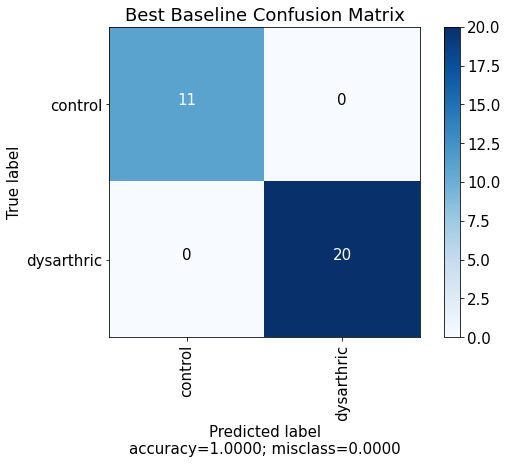

In [79]:
modelx=keras.models.load_model('checkpoints/best_base_demo4d.hdf5') 
y_pred=modelx.predict(x_valid)
y_pred1 = (y_pred > 0.5) 

y_pred=np.argmax(y_pred, axis=1)
print('\nConv Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
cm = metrics.confusion_matrix(y_test, y_pred)


plot_confusion_matrix(cm , 
                      normalize    = False,
                      target_names = labels,
                      title        = "Best Baseline Confusion Matrix")

In [80]:
## For Quanv Exp.
early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                           verbose=1, patience=10, min_delta=0.0001)

checkpoint = ModelCheckpoint('checkpoints/best_conv_demo4d.hdf5', monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')

if net == 0:
    modelc= dense_Model(x_train[0], labels)
elif net == 1:
    modelc = attrnn_Model(x_train[0], labels,use_cnn=True)
    

#modelc = keras.models.load_model('checkpoints/0910_1843_base_sp2cmd.hdf5')
modelc.summary()

c_history = modelc.fit(
    x=x_train, 
    y=y_train,
    epochs=eps, 
    callbacks=[checkpoint], 
    batch_size=bsize, 
    validation_data=(x_valid,y_valid)
)

keras.models.save_model(modelc, 'checkpoints/'+ data_ix + '_conv_model_demo4d.hdf5') 
modelc.save('checkpoints/'+ data_ix + '_conv_demo4d.hdf5')

print("=== Batch Size: ", bsize)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 60, 751, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 60, 751, 32)  320         ['input_12[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)           (None, 30, 375, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 30, 375, 64)  18496       ['pool1[0][0]']            

C:\Users\gueha\anaconda3\envs\quantum\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


8/8 [==============================] - ETA: 0s - loss: 0.6622 - accuracy: 0.6475
Epoch 1: val_accuracy improved from -inf to 0.64516, saving model to checkpoints\best_conv_demo4d.hdf5
8/8 [==============================] - 9s 535ms/step - loss: 0.6622 - accuracy: 0.6475 - val_loss: 0.6486 - val_accuracy: 0.6452
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.5664 - accuracy: 0.6721
Epoch 2: val_accuracy did not improve from 0.64516
8/8 [==============================] - 3s 348ms/step - loss: 0.5664 - accuracy: 0.6721 - val_loss: 0.7042 - val_accuracy: 0.6452
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.4079 - accuracy: 0.8361
Epoch 3: val_accuracy improved from 0.64516 to 0.83871, saving model to checkpoints\best_conv_demo4d.hdf5
8/8 [==============================] - 3s 357ms/step - loss: 0.4079 - accuracy: 0.8361 - val_loss: 0.3656 - val_accuracy: 0.8387
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.2918 - accuracy: 

Epoch 30/100
8/8 [==============================] - ETA: 0s - loss: 2.1121e-04 - accuracy: 1.0000
Epoch 30: val_accuracy did not improve from 0.96774
8/8 [==============================] - 3s 351ms/step - loss: 2.1121e-04 - accuracy: 1.0000 - val_loss: 0.3477 - val_accuracy: 0.9032
Epoch 31/100
8/8 [==============================] - ETA: 0s - loss: 1.6646e-04 - accuracy: 1.0000
Epoch 31: val_accuracy did not improve from 0.96774
8/8 [==============================] - 3s 344ms/step - loss: 1.6646e-04 - accuracy: 1.0000 - val_loss: 0.3369 - val_accuracy: 0.9032
Epoch 32/100
8/8 [==============================] - ETA: 0s - loss: 1.6722e-04 - accuracy: 1.0000
Epoch 32: val_accuracy did not improve from 0.96774
8/8 [==============================] - 3s 340ms/step - loss: 1.6722e-04 - accuracy: 1.0000 - val_loss: 0.3269 - val_accuracy: 0.9032
Epoch 33/100
8/8 [==============================] - ETA: 0s - loss: 1.7456e-04 - accuracy: 1.0000
Epoch 33: val_accuracy did not improve from 0.96774
8

Epoch 60/100
8/8 [==============================] - ETA: 0s - loss: 0.6593 - accuracy: 0.6311
Epoch 60: val_accuracy did not improve from 0.96774
8/8 [==============================] - 3s 344ms/step - loss: 0.6593 - accuracy: 0.6311 - val_loss: 0.6513 - val_accuracy: 0.6452
Epoch 61/100
8/8 [==============================] - ETA: 0s - loss: 0.6609 - accuracy: 0.6311
Epoch 61: val_accuracy did not improve from 0.96774
8/8 [==============================] - 3s 341ms/step - loss: 0.6609 - accuracy: 0.6311 - val_loss: 0.6520 - val_accuracy: 0.6452
Epoch 62/100
8/8 [==============================] - ETA: 0s - loss: 0.6593 - accuracy: 0.6311
Epoch 62: val_accuracy did not improve from 0.96774
8/8 [==============================] - 3s 341ms/step - loss: 0.6593 - accuracy: 0.6311 - val_loss: 0.6507 - val_accuracy: 0.6452
Epoch 63/100
8/8 [==============================] - ETA: 0s - loss: 0.6607 - accuracy: 0.6311
Epoch 63: val_accuracy did not improve from 0.96774
8/8 [========================

Epoch 90/100
8/8 [==============================] - ETA: 0s - loss: 0.6594 - accuracy: 0.6311
Epoch 90: val_accuracy did not improve from 0.96774
8/8 [==============================] - 3s 358ms/step - loss: 0.6594 - accuracy: 0.6311 - val_loss: 0.6510 - val_accuracy: 0.6452
Epoch 91/100
8/8 [==============================] - ETA: 0s - loss: 0.6613 - accuracy: 0.6311
Epoch 91: val_accuracy did not improve from 0.96774
8/8 [==============================] - 3s 355ms/step - loss: 0.6613 - accuracy: 0.6311 - val_loss: 0.6528 - val_accuracy: 0.6452
Epoch 92/100
8/8 [==============================] - ETA: 0s - loss: 0.6595 - accuracy: 0.6311
Epoch 92: val_accuracy did not improve from 0.96774
8/8 [==============================] - 3s 367ms/step - loss: 0.6595 - accuracy: 0.6311 - val_loss: 0.6512 - val_accuracy: 0.6452
Epoch 93/100
8/8 [==============================] - ETA: 0s - loss: 0.6590 - accuracy: 0.6311
Epoch 93: val_accuracy did not improve from 0.96774
8/8 [========================

1/1 [==============================] - 1s 1s/step

Base Accuracy: 0.65



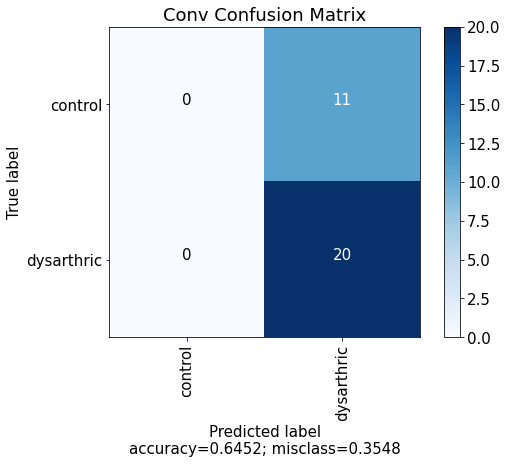

In [81]:
y_pred=modelc.predict(x_valid)
y_pred1 = (y_pred > 0.5) 

y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_valid, axis=1)

print('\nBase Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
cm = metrics.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm , 
                      normalize    = False,
                      target_names = labels,
                      title        = "Conv Confusion Matrix")

1/1 [==============================] - 1s 1s/step

Base Accuracy: 0.97



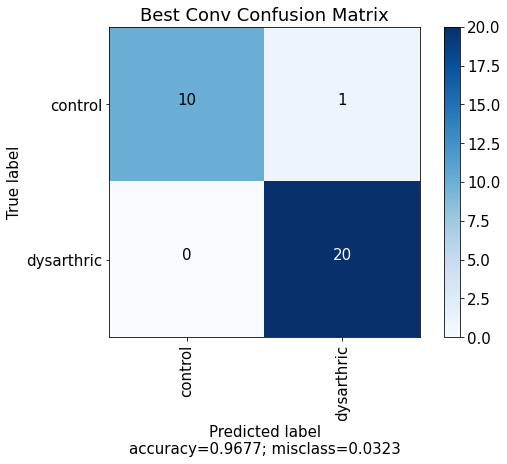

In [82]:
modelc=keras.models.load_model('checkpoints/best_conv_demo4d.hdf5') 
y_pred=modelc.predict(x_valid)
y_pred1 = (y_pred > 0.5) 

y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_valid, axis=1)

print('\nBase Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
cm = metrics.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm , 
                      normalize    = False,
                      target_names = labels,
                      title        = "Best Conv Confusion Matrix")

In [83]:
if ql1 == 1:
    ## For Quanv Exp.
    early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                               verbose=1, patience=10, min_delta=0.0001)

    checkpoint = ModelCheckpoint('checkpoints/best_quanv_demo41d.hdf5', monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')
    if net == 0:
        modelq = dense_Model(x_train[0], labels)
    elif net == 1:
        modelq1 = attrnn_Model(q_train1[0], labels)

    modelq1.summary()

    q_history1 = modelq1.fit(
        x=q_train1, 
        y=y_train,
        epochs=eps, 
        callbacks=[checkpoint], 
        batch_size=bsize, 
        validation_data=(q_valid1,y_valid)
    )

    keras.models.save_model(modelq1, 'checkpoints/'+ data_ix + '_quanv_model_demo41d.hdf5') 
    modelq1.save('checkpoints/'+ data_ix + '_demo41d.hdf5')

    print("=== Batch Size: ", bsize)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 30, 375, 4)  0           []                               
                                ]                                                                 
                                                                                                  
 batch_normalization_30 (BatchN  (None, 30, 375, 4)  16          ['input_14[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 permute_6 (Permute)            (None, 375, 30, 4)   0           ['batch_normalization_30[0][0]'] 
                                                                                            

C:\Users\gueha\anaconda3\envs\quantum\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


8/8 [==============================] - ETA: 0s - loss: 0.6791 - accuracy: 0.6066
Epoch 1: val_accuracy improved from -inf to 0.64516, saving model to checkpoints\best_quanv_demo41d.hdf5
8/8 [==============================] - 8s 448ms/step - loss: 0.6791 - accuracy: 0.6066 - val_loss: 0.6537 - val_accuracy: 0.6452
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.5647 - accuracy: 0.6557
Epoch 2: val_accuracy did not improve from 0.64516
8/8 [==============================] - 3s 323ms/step - loss: 0.5647 - accuracy: 0.6557 - val_loss: 0.6506 - val_accuracy: 0.6452
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.3880 - accuracy: 0.8197
Epoch 3: val_accuracy did not improve from 0.64516
8/8 [==============================] - 3s 321ms/step - loss: 0.3880 - accuracy: 0.8197 - val_loss: 0.7439 - val_accuracy: 0.6452
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.4999 - accuracy: 0.7705
Epoch 4: val_accuracy did not improve from 0.6

8/8 [==============================] - ETA: 0s - loss: 4.2913e-04 - accuracy: 1.0000
Epoch 30: val_accuracy did not improve from 0.87097
8/8 [==============================] - 3s 325ms/step - loss: 4.2913e-04 - accuracy: 1.0000 - val_loss: 1.9624 - val_accuracy: 0.6452
Epoch 31/100
8/8 [==============================] - ETA: 0s - loss: 2.8846e-04 - accuracy: 1.0000
Epoch 31: val_accuracy did not improve from 0.87097
8/8 [==============================] - 3s 329ms/step - loss: 2.8846e-04 - accuracy: 1.0000 - val_loss: 1.9695 - val_accuracy: 0.6452
Epoch 32/100
8/8 [==============================] - ETA: 0s - loss: 2.5483e-04 - accuracy: 1.0000
Epoch 32: val_accuracy did not improve from 0.87097
8/8 [==============================] - 3s 323ms/step - loss: 2.5483e-04 - accuracy: 1.0000 - val_loss: 1.9749 - val_accuracy: 0.6452
Epoch 33/100
8/8 [==============================] - ETA: 0s - loss: 2.3795e-04 - accuracy: 1.0000
Epoch 33: val_accuracy did not improve from 0.87097
8/8 [=========

Epoch 59/100
8/8 [==============================] - ETA: 0s - loss: 9.7106e-05 - accuracy: 1.0000
Epoch 59: val_accuracy did not improve from 0.87097
8/8 [==============================] - 3s 334ms/step - loss: 9.7106e-05 - accuracy: 1.0000 - val_loss: 0.3965 - val_accuracy: 0.8710
Epoch 60/100
8/8 [==============================] - ETA: 0s - loss: 8.5451e-05 - accuracy: 1.0000
Epoch 60: val_accuracy improved from 0.87097 to 0.96774, saving model to checkpoints\best_quanv_demo41d.hdf5
8/8 [==============================] - 3s 337ms/step - loss: 8.5451e-05 - accuracy: 1.0000 - val_loss: 0.2852 - val_accuracy: 0.9677
Epoch 61/100
8/8 [==============================] - ETA: 0s - loss: 8.0124e-05 - accuracy: 1.0000
Epoch 61: val_accuracy did not improve from 0.96774
8/8 [==============================] - 3s 321ms/step - loss: 8.0124e-05 - accuracy: 1.0000 - val_loss: 0.2291 - val_accuracy: 0.9677
Epoch 62/100
8/8 [==============================] - ETA: 0s - loss: 8.4204e-05 - accuracy: 1.0

8/8 [==============================] - 3s 326ms/step - loss: 5.3425e-05 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 88/100
8/8 [==============================] - ETA: 0s - loss: 4.9952e-05 - accuracy: 1.0000
Epoch 88: val_accuracy did not improve from 1.00000
8/8 [==============================] - 3s 322ms/step - loss: 4.9952e-05 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 89/100
8/8 [==============================] - ETA: 0s - loss: 4.8185e-05 - accuracy: 1.0000
Epoch 89: val_accuracy did not improve from 1.00000
8/8 [==============================] - 3s 323ms/step - loss: 4.8185e-05 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 90/100
8/8 [==============================] - ETA: 0s - loss: 4.7073e-05 - accuracy: 1.0000
Epoch 90: val_accuracy did not improve from 1.00000
8/8 [==============================] - 3s 322ms/step - loss: 4.7073e-05 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 91/100
8/8 [

In [59]:
if ql2 == 1:
    ## For Quanv Exp.
    early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                               verbose=1, patience=10, min_delta=0.0001)

    checkpoint = ModelCheckpoint('checkpoints/best_quanv_demo42.hdf5', monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')
    if net == 0:
        modelq = dense_Model(x_train[0], labels)
    elif net == 1:
        modelq2 = attrnn_Model(q_train2[0], labels)
    modelq2.summary()

    q_history2 = modelq2.fit(
        x=q_train2, 
        y=y_train,
        epochs=eps, 
        callbacks=[checkpoint], 
        batch_size=bsize, 
        validation_data=(q_valid2,y_valid)
    )

    keras.models.save_model(modelq2, 'checkpoints/'+ data_ix + '_quanv_mode_demo42.hdf5') 
    modelq2.save('checkpoints/'+ data_ix + '_demo42.hdf5')

    print("=== Batch Size: ", bsize)

In [60]:
if ql3 == 1:
    ## For Quanv Exp.
    early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                               verbose=1, patience=10, min_delta=0.0001)

    checkpoint = ModelCheckpoint('checkpoints/best_quanv_demo43.hdf5', monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')
    if net == 0:
        modelq = dense_Model(x_train[0], labels)
    elif net == 1:
        modelq3 = attrnn_Model(q_train3[0], labels)

    modelq3.summary()

    q_history3 = modelq3.fit(
        x=q_train3, 
        y=y_train,
        epochs=eps, 
        callbacks=[checkpoint], 
        batch_size=bsize, 
        validation_data=(q_valid3,y_valid)
    )

    keras.models.save_model(modelq3, 'checkpoints/'+ data_ix + '_quanv_mode_demo43.hdf5') 
    modelq3.save('checkpoints/'+ data_ix + '_demo43.hdf5')

    print("=== Batch Size: ", bsize)

In [61]:
if ql4 == 1:
    ## For Quanv Exp.
    early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                               verbose=1, patience=10, min_delta=0.0001)

    checkpoint = ModelCheckpoint('checkpoints/best_quanv_demo44.hdf5', monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')
    if net == 0:
        modelq = dense_Model(x_train[0], labels)
    elif net == 1:
        modelq4 = attrnn_Model(q_train4[0], labels)
    modelq4.summary()

    q_history4 = modelq4.fit(
        x=q_train4, 
        y=y_train,
        epochs=eps, 
        callbacks=[checkpoint], 
        batch_size=bsize, 
        validation_data=(q_valid4,y_valid)
    )

    keras.models.save_model(modelq4, 'checkpoints/'+ data_ix + '_quanv_model_demo44.hdf5') 
    modelq4.save('checkpoints/'+ data_ix + '_demo44.hdf5')

    print("=== Batch Size: ", bsize)

4/4 [==============================] - 0s 122ms/step

Quanv Train Accuracy: 1.00


Quanv Valid Accuracy: 1.00



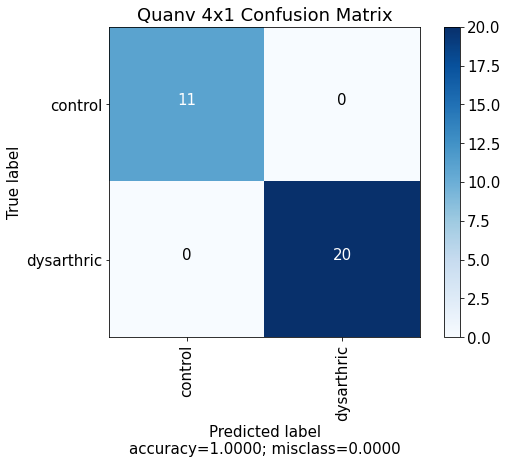

In [84]:
if ql1 == 1:
    modelq=keras.models.load_model('checkpoints/best_quanv_demo41d.hdf5') 
    y_pred=modelq.predict(q_valid1)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train1)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Quanv 4x1 Confusion Matrix")

In [63]:
if ql2 == 1:
    modelq=keras.models.load_model('checkpoints/best_quanv_demo42.hdf5') 
    y_pred=modelq.predict(q_valid2)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train2)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Quanv 4x2 Confusion Matrix")

In [64]:
if ql3 == 1:
    modelq=keras.models.load_model('checkpoints/best_quanv_demo43.hdf5') 
    y_pred=modelq.predict(q_valid3)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train3)
    y_pred2= (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Quanv 4x3 Confusion Matrix")

In [65]:
if ql4 == 1:
    modelq=keras.models.load_model('checkpoints/best_quanv_demo44.hdf5') 
    y_pred=modelq.predict(q_valid4)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train4)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Quanv 4x4 Confusion Matrix")

FileNotFoundError: [Errno 2] No such file or directory: 'images/0713_2002_conv_speech_loss.png'

<Figure size 432x288 with 0 Axes>

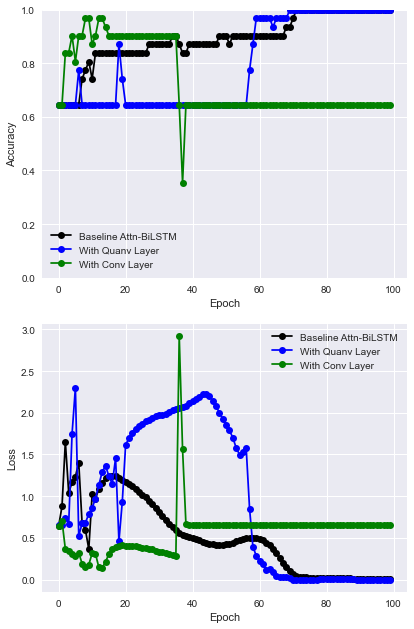

In [85]:
plot_acc_loss(q_history1, c_history, x_history, data_ix)

In [ ]:
def to_rgb2(heatmap, h_x, w_x):
    heatmap = np.uint8(255 * vis_map(np.rot90(heatmap[0])))
    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[np.rot90(np.transpose(heatmap))]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)

    jet_heatmap = jet_heatmap.resize((  h_x, w_x))

    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Save the superimposed image
    save_path = "images/color_cam.jpg"
    superimposed_img = keras.preprocessing.image.array_to_img(jet_heatmap)
    superimposed_img.save(save_path)

    cam_img= mpimg.imread(save_path)

    return cam_img

In [ ]:
from tensorflow.keras import models
import matplotlib.cm as cm
import matplotlib.image as mpimg
def layer_output(in_feats, model, ly_name = "batch_normalization_6 ", k= idx):
    conv_layer = model.get_layer(ly_name)
    heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(in_feats[k:k+1])
        loss = predictions[:, np.argmax(predictions[0])]
        grads = gtape.gradient(loss, conv_output)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    return heatmap, conv_output, predictions

In [ ]:
def vis_map(heatmap):
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    return heatmap

In [ ]:
idx = 40
w_x, h_x = x_train[idx,:,:,0].shape

#q_heatmap, q_covout, q_predict = layer_output(q_train1, modelq, "ConvDown2",k=idx)
#q_cam = to_rgb2(q_heatmap, h_x, w_x)

x_heatmap, x_covout, x_predict= layer_output(x_train, modelx, "ConvDown2",k=idx)
x_cam = to_rgb2(x_heatmap, h_x, w_x)

c_heatmap, c_covout, c_predict = layer_output(x_train, modelc, "ConvDown2",k=idx)
c_cam = to_rgb2(c_heatmap, h_x, w_x)

In [ ]:
a = 12
plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(librosa.power_to_db(x_train[idx,:,:,0], ref=np.max))
plt.xticks([])
plt.yticks([])
plt.title('(a) Input Mel-Spectrogram', fontsize=a)
# plt.matshow(np.transpose(vis_map(x_train[idx,:,:,0])))
plt.subplot(2, 2, 2)
plt.imshow(q_cam)
plt.xticks([])
plt.yticks([])
plt.title('(b) Quanv + RNN', fontsize=a)
plt.subplot(2 ,2, 3)
plt.imshow(x_cam)
plt.xticks([])
plt.yticks([])
plt.title('(c) Conv + RNN', fontsize=a)
plt.subplot(2 ,2, 4)
plt.imshow(c_cam)
plt.xticks([])
plt.yticks([])
plt.title('(d) Baseline RNN', fontsize=a)
plt.tight_layout()
plt.savefig("images/cam_sp_"+str(idx)+".png")